#Hometask 2 (Neural networks course, BSU)

Finding pneumonia on a chest x-ray.

##Preparing data

###Loading data

In [ ]:
from gfile import download_list

download_list(
    url='https://drive.google.com/file/d/1QGqTrHmZC5gO-zyK0Y8F_Llgo2XFkOHL',
    filename='data.zip',
    target_dir='.'
)

It took  13.25sec to download 1.1 GB data.zip 


In [ ]:
!unzip data.zip

In [ ]:
import numpy as np
import pandas as pd
import torch

import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage
from torchvision import transforms
%matplotlib inline



###Creating datasets

In [ ]:
from pathlib import Path
from torch.utils.data import Dataset
from skimage import io
from PIL import Image
import random
import cv2
from skimage import color
from skimage.transform import rotate, AffineTransform, warp
import torch
from PIL import Image

TRAIN_SIZE = 0.91

def make_train_set(array):
    last_elem_ind = int(len(array) * TRAIN_SIZE)
    return array[:last_elem_ind]

def make_val_set(array):
    first_elem_ind = int(len(array) * TRAIN_SIZE)
    return array[first_elem_ind:]


class XRayDataset(Dataset):

    def __init__(self, root_dir, root_dir_second=None, with_label=True, transform=None, training=True ):
        self.with_label = with_label
        self.training = training
        self.transform = transform
        self.paths = list(sorted(Path(root_dir).iterdir()))
        if self.with_label:
            
            self.paths_second = list(sorted(Path(root_dir_second).iterdir()))
            if self.training:
                self.paths = make_train_set(self.paths)
                self.paths_second = make_train_set(self.paths_second)
                print(self.paths[-1])
                print(self.paths_second[-1])
            else:
                self.paths = make_val_set(self.paths)
                self.paths_second = make_val_set(self.paths_second)
                print(self.paths[0])
                print(self.paths_second[0])
            print(f'First dir: {len(self.paths)} elements')
            print(f'Second dir: {len(self.paths_second)} elements')

        else:
            '''self.paths = list(sorted(Path(root_dir).iterdir()))
            print(self.paths)'''
            print(f'First dir: {len(self.paths)} elements')


    def __len__(self):
        if self.with_label:
            if self.training:
                return (len(self.paths) * 3 + len(self.paths_second))
            else:
                 return (len(self.paths) + len(self.paths_second))
        return len(self.paths)

    def __getitem__(self, index):
        if not self.with_label:
             image = skimage.io.imread(self.paths[index])
             # image = image.transpose((2,0,1))
             # image = torch.from_numpy(image).float()
             if self.transform is not None:
                 image = self.transform(Image.fromarray(image))
             return image

        if self.training:
            coef = 3
        else:
            coef = 1
        
        
        idx = index % len(self)
        if idx < len(self.paths) * coef:
            idx = idx % len(self.paths)
            label = 0
            image = skimage.io.imread(self.paths[idx])
        else:
            label = 1
            image = skimage.io.imread(self.paths_second[idx - len(self.paths) * coef])
        # image = color.rgb2gray(image)
        # image = image.transpose((2,0,1))
        # image = torch.from_numpy(image).float()
        # image = torch.from_numpy(np.expand_dims(image / 255. , axis=0)).float()
        #print(image.shape)
        if self.transform is not None:
            image = self.transform(Image.fromarray(image))
        return image, label #, torch.from_numpy(np.expand_dims(skimage.io.imread(self.paths[idx]).transpose((2,0,1)) / 255, axis=0)).float()

In [ ]:
IMG_SIZE=128

transform_train = transforms.Compose([
      transforms.Grayscale(),                        
      transforms.Resize((IMG_SIZE,IMG_SIZE)),
      transforms.RandomHorizontalFlip(),
#      transforms.RandomRotation([-8,8]),
      transforms.RandomAffine(degrees=(-7, 7), translate=(0. , 0.05), scale=(0.9, 1.1), shear=0),
      transforms.ToTensor()
])


transform_test = transforms.Compose([
    transforms.Grayscale(),                       
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor()
])


In [ ]:
train_dataset = XRayDataset(root_dir='chest_xray/chest_xray/train/NORMAL',
                            root_dir_second='chest_xray/chest_xray/train/PNEUMONIA',
                            transform=transform_train)
val_dataset = XRayDataset(root_dir='chest_xray/chest_xray/train/NORMAL',
                            root_dir_second='chest_xray/chest_xray/train/PNEUMONIA',
                            training=False,
                            transform=transform_test)
test_dataset = XRayDataset(root_dir='chest_xray/chest_xray/test',
                           with_label=False,
                           transform=transform_test)




chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1244-0001.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person796_virus_1428.jpeg
First dir: 1227 elements
Second dir: 3533 elements
chest_xray/chest_xray/train/NORMAL/NORMAL2-IM-1245-0001.jpeg
chest_xray/chest_xray/train/PNEUMONIA/person797_virus_1429.jpeg
First dir: 122 elements
Second dir: 350 elements
First dir: 624 elements


In [ ]:
len(train_dataset)

7214

Let's look on images from datasets.

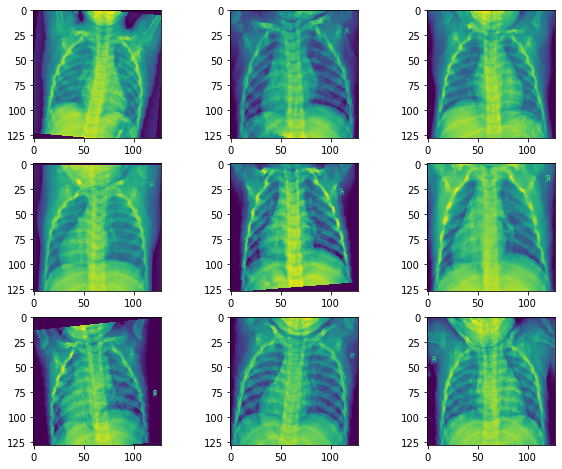

In [ ]:
# NORMAL
plt.figure(figsize=(10,8))

for i in range(9):

    plt.subplot(3,3,i+1)
    # print(train_dataset[i])
    im = skimage.img_as_ubyte(train_dataset[i][0])
    plt.imshow(im[0])

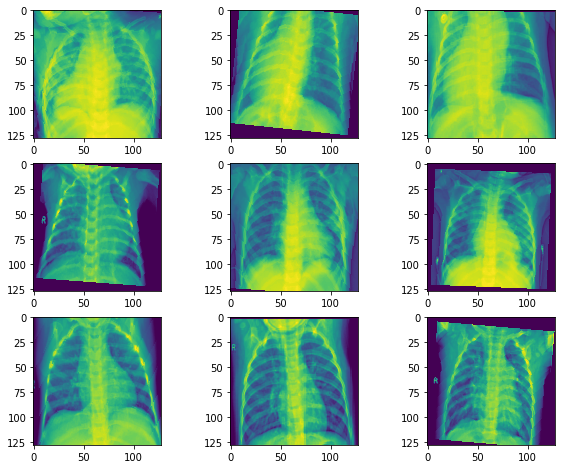

In [ ]:
# PNEUMONIA
plt.figure(figsize=(10,8))

for i in range(4000,4009):

    plt.subplot(3,3,i+1-4000)
    # print(train_dataset[i])
    im = skimage.img_as_ubyte(train_dataset[i][0])
    plt.imshow(im[0])

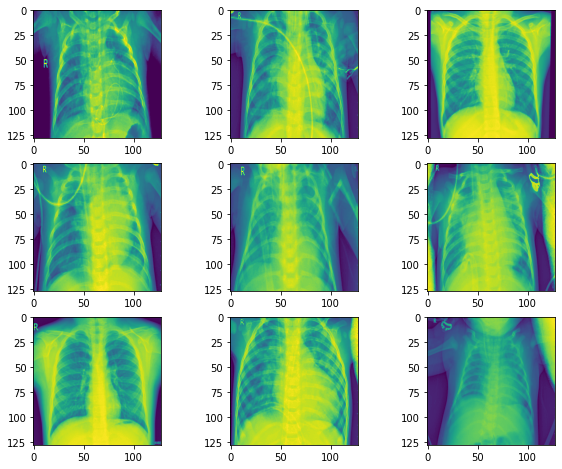

In [ ]:
# TEST
plt.figure(figsize=(10,8))

for i in range(9):

    plt.subplot(3,3,i+1)
    # print(train_dataset[i])
    im = skimage.img_as_ubyte(test_dataset[i][0])
    plt.imshow(im)

##Building a network

In [ ]:


import torch
import torch.nn.functional as F
from torch import nn
import torchvision.models as models

    



class ModelBasedMobileNetV3(nn.Module):
    def __init__(self, target_size=512):
        super().__init__()

        mobilenet_v3 = models.mobilenet_v3_large(pretrained=True)
        self.model = nn.Sequential(nn.Conv2d(1, 3, kernel_size=1))
        basic = nn.Sequential(*[mobilenet_v3.features[i] for i in range(9)])  
        self.model.add_module('basic', basic)
        '''convs =  nn.Sequential(
            nn.Conv2d(80, 120, kernel_size=3),
            nn.BatchNorm2d(120),
            nn.ReLU(),
            # nn.Conv2d()
        )
        self.model.add_module('convs', convs)'''
        final = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5120, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 2),
            nn.Softmax()
            )
        self.model.add_module('final', final)

    def forward(self, x):
        out = self.model(x)
        return out 



In [ ]:
model = ModelBasedMobileNetV3().cuda()

In [ ]:
from torchsummary import summary

summary(model, (1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 128, 128]               6
            Conv2d-2           [-1, 16, 64, 64]             432
       BatchNorm2d-3           [-1, 16, 64, 64]              32
         Hardswish-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 16, 64, 64]             144
       BatchNorm2d-6           [-1, 16, 64, 64]              32
              ReLU-7           [-1, 16, 64, 64]               0
            Conv2d-8           [-1, 16, 64, 64]             256
       BatchNorm2d-9           [-1, 16, 64, 64]              32
         Identity-10           [-1, 16, 64, 64]               0
 InvertedResidual-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]           1,024
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


##Training

Epoch 30 of 30 took 99.427s
  training loss (in-iteration): 	0.319345
  validation loss (in-iteration): 	0.337696
  validation auc: 			0.995504 


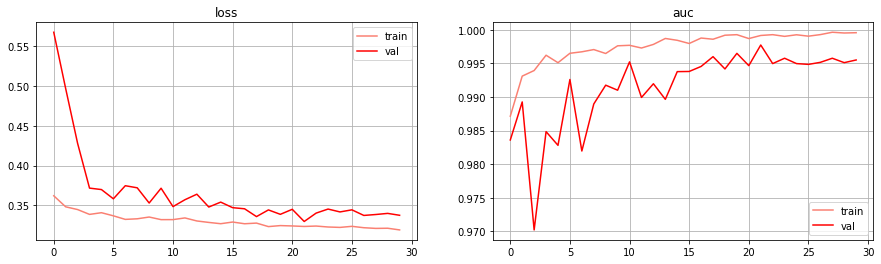

In [ ]:
import gc
import time

from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
from sklearn import metrics

num_epochs = 30 # total amount of full passes over training data
batch_size = 32  # number of samples processed in one SGD iteration

train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=2)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=2)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=0.95)
criterion = nn.CrossEntropyLoss() #nn.BCELoss()

train_losses = []

val_losses = []
auc_values = []
auc_values_train = []


for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    start_time = time.time()
    model.train(True) # enable dropout / batch_norm training behavior
    train_loss = []
    y_batch_values = []
    y_pred_values = []

    for X_batch, y_batch in tqdm(train_loader):
        # train on batch

        '''raise ValueError()'''
        logits = model(Variable(torch.FloatTensor(X_batch).cuda()))

        y_pred = logits[:, 1]
        loss = criterion(logits, y_batch.cuda())
        loss.backward()
        opt.step()
        opt.zero_grad()
        train_loss.append(loss.data.cpu().numpy())
        y_batch_values.append(y_batch)
        y_pred_values.append(y_pred)
    train_losses.append(np.mean(train_loss))
    fpr, tpr, thresholds = metrics.roc_curve(torch.cat(y_batch_values).cpu().detach().numpy(), 
                                             torch.cat(y_pred_values).cpu().detach().numpy(),
                                             pos_label=1)
    #auc = accuracy_score(torch.cat(y_batch_values).cpu() , torch.cat(y_pred_values).cpu())
    auc = metrics.auc(fpr, tpr)
    auc_values_train.append(auc)
    # And a full pass over the validation data:
    model.train(False) # disable dropout / use averages for batch_norm
    y_batch_values = []
    y_pred_values = []
    val_loss = []
    for X_batch, y_batch in tqdm(val_loader, desc="val"):
        logits = model(Variable(torch.FloatTensor(X_batch).cuda()))

        y_pred = logits[:, 1]
        loss = criterion(logits, y_batch.cuda())
        val_loss.append(loss.data.cpu().numpy())
        #gc.collect(y_pred)
        #val_accuracy = accuracy_score(y_batch, y_pred)
        y_batch_values.append(y_batch)
        y_pred_values.append(y_pred)
    val_losses.append(np.mean(val_loss))
    # Then we print the results for this epoch:
    clear_output()
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))
    print("  training loss (in-iteration): \t{:.6f}".format(train_losses[-1]))
    print("  validation loss (in-iteration): \t{:.6f}".format(val_losses[-1]))
    fpr, tpr, thresholds = metrics.roc_curve(torch.cat(y_batch_values).cpu().detach().numpy(), 
                                             torch.cat(y_pred_values).cpu().detach().numpy(),
                                             pos_label=1)
    #auc = accuracy_score(torch.cat(y_batch_values).cpu() , torch.cat(y_pred_values).cpu())
    auc = metrics.auc(fpr, tpr)
    auc_values.append(auc)
    print("  validation auc: \t\t\t{:.6f} ".format(auc))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
 
    ax1.set_title('loss')
    ax1.plot(train_losses, label='train', color='salmon')
    ax1.plot(val_losses, label='val', color='red')
    ax1.legend()
    ax1.grid()
 
    ax2.set_title('auc')
    ax2.plot(auc_values_train, label='train', color='salmon')
    ax2.plot(auc_values, label='val', color='red')
    ax2.legend()
    ax2.grid()

 
    plt.show()
    lr_scheduler.step()
    torch.cuda.empty_cache()


In [ ]:
np.max(auc_values)

0.997728337236534

##Predicting

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=64, shuffle=False,
                                             num_workers=1)

###Making predictions

In [ ]:
from tqdm import tqdm_notebook as tqdm
from torch.autograd import Variable
model.train(False) # disable dropout / use averages for batch_norm

y_pred_values = []

for X_batch in tqdm(test_loader, desc="val"):
    logits = model(Variable(torch.FloatTensor(X_batch).cuda())).cpu()

    y_pred = logits[:, 1]
    #print(y_pred)

    y_pred_values.append(y_pred)
    torch.cuda.empty_cache()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
y_pred = torch.cat(y_pred_values).cpu().detach().numpy()

y_pred

array([1.00000000e+00, 1.00000000e+00, 2.23886509e-05, 1.00000000e+00,
       9.99999881e-01, 1.00000000e+00, 1.17245705e-07, 1.00000000e+00,
       9.99997020e-01, 1.00000000e+00, 3.91558260e-02, 6.15513684e-08,
       7.78959215e-01, 9.99427617e-01, 9.99999523e-01, 9.99999762e-01,
       9.99999881e-01, 1.03953617e-11, 9.99177277e-01, 9.99998331e-01,
       9.99999881e-01, 1.00000000e+00, 9.99999404e-01, 1.00000000e+00,
       9.99958515e-01, 9.99691010e-01, 1.00000000e+00, 9.99323845e-01,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.08492050e-05,
       2.19951037e-11, 9.99999762e-01, 6.89849432e-04, 9.99993920e-01,
       1.00000000e+00, 9.83880341e-01, 1.00000000e+00, 3.22871795e-03,
       2.64075905e-01, 9.99999881e-01, 3.77370976e-02, 1.00000000e+00,
       9.99975681e-01, 9.98231351e-01, 5.42290567e-04, 9.65888969e-09,
       9.99996185e-01, 1.00000000e+00, 1.00000000e+00, 6.02856744e-07,
       1.54500892e-08, 9.99999881e-01, 9.99996185e-01, 1.00000000e+00,
      

In [ ]:
np.count_nonzero(y_pred < 0.5)

172

###Transforming predictions

In [ ]:
files_probs = [ [str(test_dataset.paths[i])[(10 + 1 + 10 + 1):], y_pred[i]] for i in np.arange(len(y_pred))]

In [ ]:
df = pd.DataFrame(files_probs, columns=['filename', 'probability'])
df

,filename,probability
0,test/1.jpeg,1.000000
1,test/10.jpeg,1.000000
2,test/100.jpeg,0.000022
3,test/101.jpeg,1.000000
4,test/102.jpeg,1.000000
...,...,...
619,test/95.jpeg,0.000002
620,test/96.jpeg,0.999999
621,test/97.jpeg,0.999911
622,test/98.jpeg,1.000000


###Saving predictions

In [ ]:
df.to_csv('pred.csv', index=False)